# CENTRALITY IS ALL YOU NEED
## LFN Project

### Description of the project
- **Aim**: try to detect the most influential political figures and their political party.

## Load libraries

In [1]:
#!pip install networkit
#!pip install pyvis
import networkx as nx
import networkit as nk
import csv
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from pyvis.network import Network
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

## Loading of the graph and calculation of some metrics

In [2]:
edges = pd.read_csv("data/fb-pages-politician.edges", sep = ",", header=None)
nodes = pd.read_csv("data/fb-pages-politician.nodes", sep = ",")

In [3]:
nodes

,id,name,new_id
0,127397457601670,陳根德,1661
1,169014523134260,林淑芬,52
2,295363753921281,Chris White,3477
3,613631835423903,Stewart Hosie MP,3193
4,284882801581896,Frank Schäffler,4425
...,...,...,...
5903,342943772496246,Kevin Byrne,3778
5904,193944157325672,Timur Husein,439
5905,142026376065,Jeremy Lefroy,159
5906,294019144024664,Ileana Argentin,107


In [4]:
#needs a dictionary in order to relabel the nodes
labelsDict = pd.Series(nodes.name.values,index=nodes.new_id).to_dict()

In [5]:
G = nx.Graph()
G = nx.from_pandas_edgelist(edges,0, 1)
G = nx.relabel_nodes(G, labelsDict)

In [6]:
G.is_directed()

False

In [7]:
nkG = nk.nxadapter.nx2nk(G)

In [72]:
import math
41702/(math.factorial(5906)/(2*math.factorial(5904)))

0.002391517344981051

In [8]:
print("Is G connected? ",nx.is_connected(G))
print("Number of connected components: ", nx.number_connected_components(G))

Is G connected?  True
Number of connected components:  1


In [9]:
#connected components with networkit
cc = nk.components.ConnectedComponents(nkG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())

number of components  1
map of component size:  {0: 5906}


In [10]:
#diameter (estimate)
#This algorithm gives an estimation of the diameter of a given graph. The algorithm is based on the ExactSumSweep algorithm presented in Michele Borassi, Pierluigi Crescenzi, Michel Habib, Walter A. Kosters, Andrea Marino, Frank W. Takes: http://www.sciencedirect.com/science/article/pii/S0304397515001644.
diam = nk.distance.Diameter(nkG,algo=1)
diam.run()
diam.getDiameter() 
#The return value of getDiameter is a pair of integers: the lower bound and upper bound of the diameter. 
#In the case, that we computed the exact diameter, the diameter is the first value of the pair.

(14, 0)

In [11]:
#diameter (effective)
#The effective diameter is defined as the number of edges on average to reach a given ratio of all other nodes.
#The EffectiveDiameter(G, ratio=0.9) constructor expects an undirected graph and the ratio of nodes that should be connected. The ratio must be between in the interval (0,1].
ed = nk.distance.EffectiveDiameter(nkG)
ed.run()
ed.getEffectiveDiameter()

5.816796478157806

In [12]:
#effective diameter approximation
eda = nk.distance.EffectiveDiameterApproximation(nkG)
eda.run()
eda.getEffectiveDiameter()

6.085506264815442

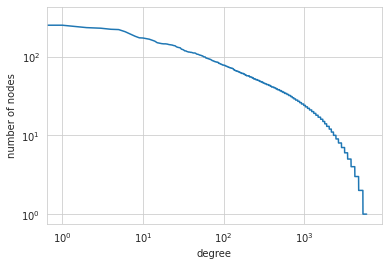

In [13]:
#degree distribution in our original graph
dd = sorted(nk.centrality.DegreeCentrality(nkG).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [14]:
#some info in our original graph if we are interested
communities = nk.community.detectCommunities(nkG)
nk.community.Modularity().getQuality(communities, nkG)

PLM(balanced,pc,turbo) detected communities in 0.009026765823364258 [s]
solution properties:
-------------------  ----------
# communities         29
min community size    18
max community size   570
avg. community size  203.655
modularity             0.867781
-------------------  ----------


0.8677807864196836

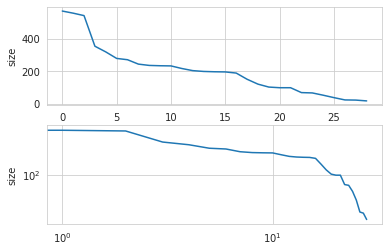

In [15]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

## Closeness and Betweenness centrality

In [16]:
def centrality(G,alg, lib):
    if alg == "closeness" and lib == "nx":
        start_time = time.time()
        colsenessCentrality_nx = nx.closeness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return colsenessCentrality_nx
    if alg == "betweenness" and lib == "nx":
        start_time = time.time()
        betweennessCentrality_nx = nx.betweenness_centrality(G)
        print("--- %s seconds ---" % (time.time() - start_time))
        return betweennessCentrality_nx
    if alg == "closeness" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkColsenessCentrality = nk.centrality.Closeness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkColsenessCentrality.ranking()
    if alg == "betweenness" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkBetweennessCentrality = nk.centrality.Betweenness(G,True,False).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkBetweennessCentrality.ranking()
    if alg == "approxclose" and lib == "nk":
        start_time = time.time()
        # default normalized=False
        nkApproxColsenessCentrality = nk.centrality.ApproxCloseness(G,100, epsilon=0.05, normalized=True).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxColsenessCentrality.ranking()
    if alg == "approxbet" and lib == "nk":
        start_time = time.time()
        nkApproxBetweennessCentrality = nk.centrality.ApproxBetweenness(G,epsilon=0.05).run()
        print("--- %s seconds ---" % (time.time() - start_time))
        return nkApproxBetweennessCentrality.ranking()

In [17]:
#centrality(G,"closeness","nx")

In [18]:
cc = centrality(nkG,"closeness","nk")

--- 0.48499393463134766 seconds ---


In [19]:
top10cc = dict(cc[:10])
keys10cc = list(top10cc.keys())
values10cc = list(top10cc.values())
nodesTop10cc = nodes[nodes["new_id"].isin(keys10cc)]
nodesTop10cc["cc"] = values10cc
nodesTop10cc

<ipython-input-19-eeca2ecd9c7e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10cc["cc"] = values10cc


,id,name,new_id,cc
385,425788730806692,Pierre Moreau,810,0.358857
1552,1008920055906510,Monika Lazar,219,0.323508
2228,1457854404494601,Hervé Gaymard,233,0.320471
2611,728842613851000,Margaret Quirk MLA,157,0.317422
4205,169196224815,Giovanni Capriglione,50,0.312467
4358,168468263243635,Sylviane Bulteau,703,0.310855
4900,449533531817208,Alejandra Morlan,228,0.309697
5193,336733203010225,Assemblyman Ray Walter,853,0.307536
5227,384662044972285,"Norbert Spinrath, MdB",941,0.305547
5327,232363686957754,Alexander Kulitz,855,0.305152


In [20]:
#centrality(G,"betweenness","nx")

In [21]:
bc = centrality(nkG,"betweenness","nk")

--- 4.408867835998535 seconds ---


In [22]:
top10bc = dict(bc[:10])
keys10bc = list(top10bc.keys())
values10bc = list(top10bc.values())
nodesTop10bc = nodes[nodes["new_id"].isin(keys10bc)]
nodesTop10bc["bc"] = values10bc
nodesTop10bc

<ipython-input-22-148da339cf7a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10bc["bc"] = values10bc


,id,name,new_id,bc
385,425788730806692,Pierre Moreau,810,0.536616
592,397307097023253,Justine Elliot MP,140,0.111042
2490,229547190392110,"Laurin Liu, Candidate NPD, RDMI",951,0.108292
2611,728842613851000,Margaret Quirk MLA,157,0.096549
2972,662955787059972,Shane King MP- Labor for Kurwongbah,138,0.090176
2981,326547101058452,Reinhard Brandl,255,0.074552
3194,148900938515423,Sofie Carsten Nielsen,177,0.070736
3237,9094598058,Leopoldo Lopez,638,0.068160
4205,169196224815,Giovanni Capriglione,50,0.063586
4358,168468263243635,Sylviane Bulteau,703,0.057986


In [23]:
acc = centrality(nkG,"approxclose","nk")

--- 0.046968936920166016 seconds ---


In [24]:
top10acc = dict(acc[:10])
keys10acc = list(top10acc.keys())
values10acc = list(top10acc.values())
nodesTop10acc = nodes[nodes["new_id"].isin(keys10acc)]
nodesTop10acc["acc"] = values10acc
nodesTop10acc

<ipython-input-24-155343c7ba8d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10acc["acc"] = values10acc


,id,name,new_id,acc
385,425788730806692,Pierre Moreau,810,0.346021
1537,113077252063553,Bronisław Komorowski,57,0.305810
1552,1008920055906510,Monika Lazar,219,0.303951
2611,728842613851000,Margaret Quirk MLA,157,0.303030
4205,169196224815,Giovanni Capriglione,50,0.302115
4358,168468263243635,Sylviane Bulteau,703,0.301205
4900,449533531817208,Alejandra Morlan,228,0.294985
5193,336733203010225,Assemblyman Ray Walter,853,0.293255
5227,384662044972285,"Norbert Spinrath, MdB",941,0.292398
5327,232363686957754,Alexander Kulitz,855,0.292398


In [25]:
abc = centrality(nkG,"approxbet","nk")

--- 0.9048042297363281 seconds ---


In [26]:
top10abc = dict(abc[:10])
keys10abc = list(top10abc.keys())
values10abc = list(top10abc.values())
nodesTop10abc = nodes[nodes["new_id"].isin(keys10abc)]
nodesTop10abc["abc"] = values10abc
nodesTop10abc

<ipython-input-26-8006ea99b19e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodesTop10abc["abc"] = values10abc


,id,name,new_id,abc
385,425788730806692,Pierre Moreau,810,0.278234
592,397307097023253,Justine Elliot MP,140,0.056468
2490,229547190392110,"Laurin Liu, Candidate NPD, RDMI",951,0.049966
2611,728842613851000,Margaret Quirk MLA,157,0.049281
2663,342928465888942,Alain Leboeuf,308,0.044148
2972,662955787059972,Shane King MP- Labor for Kurwongbah,138,0.038672
2981,326547101058452,Reinhard Brandl,255,0.037303
3194,148900938515423,Sofie Carsten Nielsen,177,0.034908
4205,169196224815,Giovanni Capriglione,50,0.031485
4358,168468263243635,Sylviane Bulteau,703,0.031485


In [27]:
#visualize a subgraph
#H = G.subgraph(list(G.nodes)[:100])
#nt = Network('900px','1820px')
#nt.from_nx(H)
#nt.show('nx.html')

## Global and local clustering coefficient

In [28]:
#Returns approximate average average local clustering coefficient (networkit)
ACC_nkG = nk.globals.clustering(nkG)
ACC_nkG

0.4243463910362199

In [29]:
#Local Clustering Coefficient does not accept graphs with self loops.
#We remove them and compute the scores 
nkG.removeSelfLoops()
LCC_nkG = nk.centrality.LocalClusteringCoefficient(nkG).run()

In [30]:
len(LCC_nkG.scores()),LCC_nkG.scores()

(5906,
 [0.5739957716701902,
  0.4423558897243108,
  0.5113636363636364,
  0.819047619047619,
  0.7719298245614035,
  0.7333333333333333,
  0.7142857142857143,
  0.3745632424877708,
  0.5032377428307123,
  0.7631578947368421,
  0.3790849673202614,
  0.7350427350427351,
  0.3911421911421911,
  0.2367816091954023,
  0.5231372549019608,
  0.6102418207681366,
  0.5505050505050505,
  0.6628787878787878,
  0.7792207792207793,
  0.6413793103448275,
  0.4117647058823529,
  0.4788732394366197,
  0.7660098522167488,
  0.578494623655914,
  0.25117845117845117,
  0.4767676767676768,
  0.673202614379085,
  0.6773109243697479,
  0.4250380517503805,
  0.3841313269493844,
  0.4231578947368421,
  0.5245143385753932,
  0.8260869565217391,
  0.3886832363828662,
  0.19473180076628352,
  0.6193181818181818,
  0.37462537462537465,
  0.5285024154589372,
  0.8382352941176471,
  0.4919636617749825,
  0.3075091575091575,
  0.20425129900803024,
  0.783625730994152,
  0.4439746300211416,
  0.6623655913978495,
  0

In [31]:
#Returns average clustering coefficient with networkx
ACC_nxG = nx.average_clustering(G)
ACC_nxG

0.38526532797801083

In [32]:
#Networkx does not return an error for the self loops.
#However we obtain a dictionary of the same length, 
#so it removes implicity the self loops
LCC_nxG = nx.clustering(G)
len(LCC_nxG), LCC_nxG

(5906,
 {'Mark Bailey MP - Labor for Miller': 0.5739957716701902,
  'Jo-Ann Miller MP': 0.4423558897243108,
  'Senator Claire Moore': 0.5113636363636364,
  'Shane King MP-  Labor for Kurwongbah': 0.819047619047619,
  'Di Farmer MP': 0.7719298245614035,
  'Leanne Linard MP': 0.7333333333333333,
  'Aaron Harper MP': 0.7142857142857143,
  'Sénateur Pierre-Hugues Boisvenu': 0.3745632424877708,
  'Jackie Trad': 0.5032377428307123,
  'Jim Madden - Labor for Ipswich West': 0.7631578947368421,
  '邱志偉': 0.3790849673202614,
  'Grace Grace MP': 0.7350427350427351,
  'Senator Chris Ketter': 0.3911421911421911,
  'Bill Shorten MP': 0.2367816091954023,
  'Craig Crawford - Labor For Barron River': 0.5231372549019608,
  'Stirling Hinchliffe MP': 0.6102418207681366,
  'Mark Ryan MP': 0.5505050505050505,
  'Dr Anthony Lynham': 0.6628787878787878,
  'Joe Kelly MP': 0.7792207792207793,
  'Linus Power': 0.6413793103448275,
  'Luke Howarth': 0.4117647058823529,
  'Andrew Leigh MP': 0.4788732394366197,
  'Do

## Random Graphs

In [33]:
#Erdös-Renyi model
ERD = nk.generators.ErdosRenyiGenerator(G.number_of_nodes(), 0.2).generate()
print(ERD.numberOfNodes(), ERD.numberOfEdges())
#nk.community.detectCommunities(ERD)

5906 3488860


In [34]:
#Simple variant of Erdös-Renyi model
#The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.
CRG = nk.generators.ClusteredRandomGraphGenerator(G.number_of_nodes(), 4, 0.2, 0.002).generate()
print(CRG.numberOfNodes(), CRG.numberOfEdges())
#nk.community.detectCommunities(CRG)

5906 896601


In [35]:
#Chung-Lu model
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]
clgen = nk.generators.ChungLuGenerator(degreeSequence)
CLG = clgen.generate()
print(CLG.numberOfNodes(), CLG.numberOfEdges())
cc = nk.components.ConnectedComponents(CLG)
cc.run()
print("number of components ", cc.numberOfComponents())
print("map of component size: ", cc.getComponentSizes())
#nk.community.detectCommunities(CLG)

5906 41805
number of components  316
map of component size:  {0: 5591, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 

In [36]:
def generateRandGraphs(alg, nrGraphs, param):
    G = []
    
    if alg == "ER":
        nrNodes, prob = param
        for i in range(nrGraphs):
            ER = nk.generators.ErdosRenyiGenerator(nrNodes, prob).generate()
            G.append(ER)
    if alg == "CL":
        for i in range(nrGraphs):
            degreeSequence = param
            CL = nk.generators.ChungLuGenerator(degreeSequence).generate()
            G.append(CL)
    return G

## Significant check: z-score and p-values

In [37]:
# Generate random graphs
# let G' random graph
# let G original graph
# Compute metricslike E[F(G')], sigma[F(G')] of the random graphs 
# Compute z-score
def zscore(f,expect_FG, sigma_FG):
    #print(f,expect_FG,sigma_FG)
    z = (f - expect_FG)/sigma_FG;
    return z

# Compute p-values
# input: 
#    FG: list of features from graph G'
#    f: value of the feature from graph G

def pvalues(FG,f):
    plarger = sum(map(lambda x : x>= f, FG))/len(FG)
    psmaller = sum(map(lambda x : x<= f, FG))/len(FG)
    return plarger,psmaller



In [38]:
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]

In [39]:
def generateDataFrame(G, alg, nrGraphs, algRnd):
    if algRnd == "ER":
        RndGraphs = generateRandGraphs("ER", nrGraphs, [G.numberOfNodes(), 0.0025])
    if algRnd == "CL":
        degreeSequence = [G.degree(v) for v in G.iterNodes()]
        RndGraphs = generateRandGraphs("CL", nrGraphs, degreeSequence)
        
    if alg == "CC":
        if algRnd == "ER":
            RndFeatures = list(map(
                nk.centrality.Closeness,
                RndGraphs,
                [True for i in range(nrGraphs)],
                [False for i in range(nrGraphs)]

            ))
        else:
            RndFeatures = list(map(
                nk.centrality.Closeness,
                RndGraphs,
                [True for i in range(nrGraphs)],
                [nk.centrality.ClosenessVariant.Generalized for i in range(nrGraphs)],
            ))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"closeness","nk"))
    if alg == "BC":
        RndFeatures = list(map(nk.centrality.Betweenness,
                               RndGraphs,
                               [True for i in range(nrGraphs)],
                               [False for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"betweenness","nk"))
    if alg == "approxCC":
        RndFeatures = list(map(nk.centrality.ApproxCloseness,
                               RndGraphs,
                               [100 for i in range(nrGraphs)],
                               [0.05 for i in range(nrGraphs)],
                               [True for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"approxclose","nk"))
    if alg == "approxBC":
        RndFeatures = list(map(nk.centrality.ApproxBetweenness,
                               RndGraphs,
                               [0.05 for i in range(nrGraphs)]))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(centrality(G,"approxbet","nk"))
    
    
    if alg == "LCC":
        #Local Clustering Coefficient does not accept graphs with self loops.
        #We remove them and compute the scores 
        G.removeSelfLoops()
        RndFeatures = list(map(nk.centrality.LocalClusteringCoefficient,
                               RndGraphs
                              ))
        RndFeatures = list(tqdm(map(lambda obj: obj.run(), RndFeatures)))
        f = pd.DataFrame(nk.centrality.LocalClusteringCoefficient(G).run().ranking())
    
    RndFeaturesRanking = list(map(lambda obj: obj.ranking(), RndFeatures))
    # merge RndFeaturesRanking, we will obtain a list of (key,value) pairs 
    #representing the id of each node as key
    # and the closeness centrality as value
    RndFeaturesRankingMerged = list(itertools.chain(*RndFeaturesRanking))
    RndFeaturesRanking_df = pd.DataFrame(RndFeaturesRankingMerged)
    RndFeaturesRanking_df.columns = {"key":"key", "centrality":"value"}
    if alg == "LCC":
        RndFeaturesRanking_df.columns = {"key":"key", "clusteringCoeff":"value"}
    mean_by_key = RndFeaturesRanking_df.groupby("key").mean()
    std_by_key = RndFeaturesRanking_df.groupby("key").std()

    f.columns = {"key":"key","centrality":"value"}
    if alg == "LCC":
        f.columns = {"key":"key","clusteringCoeff":"value"}
    f = f.set_index('key').sort_index()
    if alg == "LCC":
        zscore_closeness = pd.DataFrame(zscore(f["clusteringCoeff"],mean_by_key["clusteringCoeff"],std_by_key["clusteringCoeff"]))
        zscore_closeness.columns = {"zscore"}
        zscore_closeness["clusteringCoeff_f"] = f["clusteringCoeff"]
    else:
        zscore_closeness = pd.DataFrame(zscore(f["centrality"],mean_by_key["centrality"],std_by_key["centrality"]))
        zscore_closeness.columns = {"zscore"}
        zscore_closeness["centrality_f"] = f["centrality"]
    zscore_closeness["mean_rand"] = mean_by_key
    zscore_closeness["std_rand"] = std_by_key
    return zscore_closeness

In [40]:
df_test_BC = generateDataFrame(nkG, "BC", 10, "ER")
df_test_CC = generateDataFrame(nkG, "CC", 10, "ER")
df_test_approxCC = generateDataFrame(nkG, "approxCC", 10, "ER")
df_test_approxBC = generateDataFrame(nkG, "approxBC", 10, "ER")

10it [01:00,  6.02s/it]
0it [00:00, ?it/s]

--- 4.4792070388793945 seconds ---


10it [00:05,  1.85it/s]
2it [00:00, 19.96it/s]

--- 0.4764537811279297 seconds ---


10it [00:00, 20.29it/s]
0it [00:00, ?it/s]

--- 0.04513120651245117 seconds ---


10it [00:11,  1.10s/it]


--- 1.0232887268066406 seconds ---


In [41]:
df_test_BC_CL = generateDataFrame(nkG, "BC", 10, "CL")
df_test_CC_CL = generateDataFrame(nkG, "CC", 10, "CL")
df_test_approxCC_CL = generateDataFrame(nkG, "approxCC", 10, "CL")
df_test_approxBC_CL = generateDataFrame(nkG, "approxBC", 10, "CL")

10it [00:51,  5.19s/it]
0it [00:00, ?it/s]

--- 4.727240800857544 seconds ---


10it [00:04,  2.24it/s]
0it [00:00, ?it/s]

--- 0.4951663017272949 seconds ---


10it [00:00, 22.74it/s]
0it [00:00, ?it/s]

--- 0.048296213150024414 seconds ---


10it [00:08,  1.16it/s]


--- 0.9380733966827393 seconds ---


In [42]:
df_test_CC_CL['zscore'].describe()

count    5906.000000
mean       -6.168672
std         6.871778
min       -77.986078
25%        -8.895571
50%        -4.381230
75%        -0.832912
max         4.429899
Name: zscore, dtype: float64

In [43]:
df_test_BC_CL['zscore'].clip(-100, 100).describe()

count    5895.000000
mean        8.636187
std        23.722902
min       -18.046862
25%        -0.977392
50%        -0.366034
75%         4.211933
max       100.000000
Name: zscore, dtype: float64

In [44]:
df_test_BC_CL['zscore'].describe()

count    5895.000000
mean             inf
std              NaN
min       -18.046862
25%        -0.977392
50%        -0.366034
75%         4.211933
max              inf
Name: zscore, dtype: float64

In [45]:
df_test_approxCC_CL['zscore'].describe()

count    5854.000000
mean       -6.513451
std         4.413787
min       -28.922196
25%        -8.680580
50%        -5.389300
75%        -3.364392
max        40.489711
Name: zscore, dtype: float64

In [46]:
df_test_approxBC.describe()

,zscore,centrality_f,mean_rand,std_rand
count,5906.000000,5906.000000,5906.000000,5906.000000
mean,0.595843,0.000617,0.000429,0.000446
std,13.603612,0.004192,0.000148,0.000142
min,-3.269994,0.000000,0.000040,0.000125
25%,-1.042403,0.000000,0.000325,0.000344
50%,-0.815966,0.000000,0.000411,0.000425
75%,-0.163471,0.000342,0.000523,0.000529
max,928.865360,0.266940,0.001046,0.001212


Text(0.5, 1.0, 'approxBC')

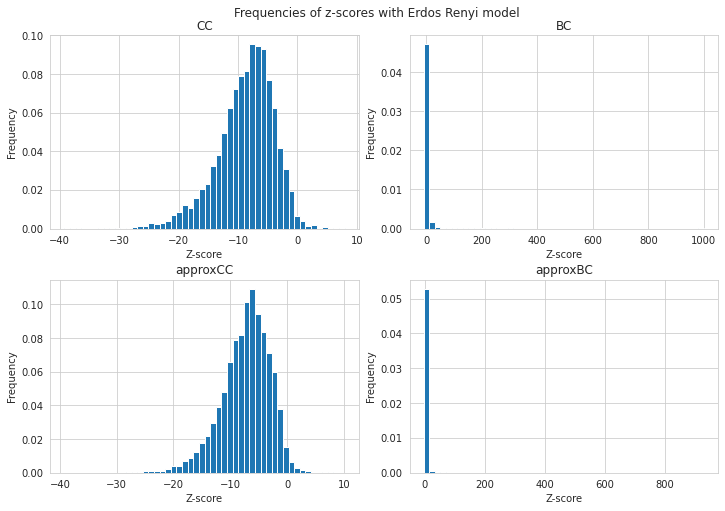

In [47]:
df_test_BC['zscore'] = df_test_BC['zscore'].clip(-1000,1000)
df_test_approxBC['zscore'] = df_test_approxBC['zscore'].clip(-1000,1000)

figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Erdos Renyi model")
figure.tight_layout(h_pad=3, w_pad=2)
axis[0,0].hist(df_test_CC['zscore'], density=True, bins=50)
axis[0,0].set_ylabel('Frequency')
axis[0,0].set_xlabel('Z-score')
axis[0,0].set_title('CC')
axis[0,1].hist(df_test_BC['zscore'], density=True, bins=50)
axis[0,1].set_ylabel('Frequency')
axis[0,1].set_xlabel('Z-score')
axis[0,1].set_title('BC')
axis[1,0].hist(df_test_approxCC['zscore'], density=True, bins=50)
axis[1,0].set_ylabel('Frequency')
axis[1,0].set_xlabel('Z-score')
axis[1,0].set_title('approxCC')
axis[1,1].hist(df_test_approxBC['zscore'], density=True, bins=50)
axis[1,1].set_ylabel('Frequency')
axis[1,1].set_xlabel('Z-score')
axis[1,1].set_title('approxBC')

/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'approxBC')

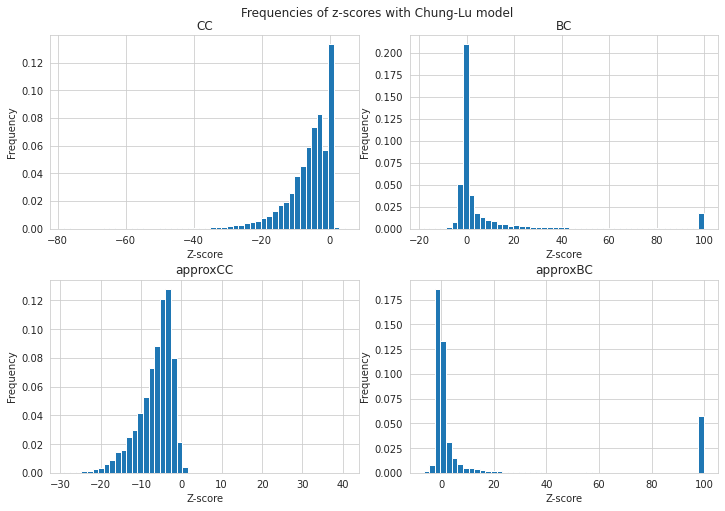

In [48]:
figure, axis = plt.subplots(2, 2, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Chung-Lu model")
figure.tight_layout(h_pad=3, w_pad=2)
axis[0,0].hist(df_test_CC_CL['zscore'], density=True, bins=50)
axis[0,0].set_ylabel('Frequency')
axis[0,0].set_xlabel('Z-score')
axis[0,0].set_title('CC')
axis[0,1].hist(df_test_BC_CL['zscore'].clip(-100, 100), density=True, bins=50)#clip bc of value inf
axis[0,1].set_ylabel('Frequency')
axis[0,1].set_xlabel('Z-score')
axis[0,1].set_title('BC')
axis[1,0].hist(df_test_approxCC_CL['zscore'], density=True, bins=50)
axis[1,0].set_ylabel('Frequency')
axis[1,0].set_xlabel('Z-score')
axis[1,0].set_title('approxCC')
axis[1,1].hist(df_test_approxBC_CL['zscore'].clip(-100, 100), density=True, bins=50)#clip bc of value inf
axis[1,1].set_ylabel('Frequency')
axis[1,1].set_xlabel('Z-score')
axis[1,1].set_title('approxBC')

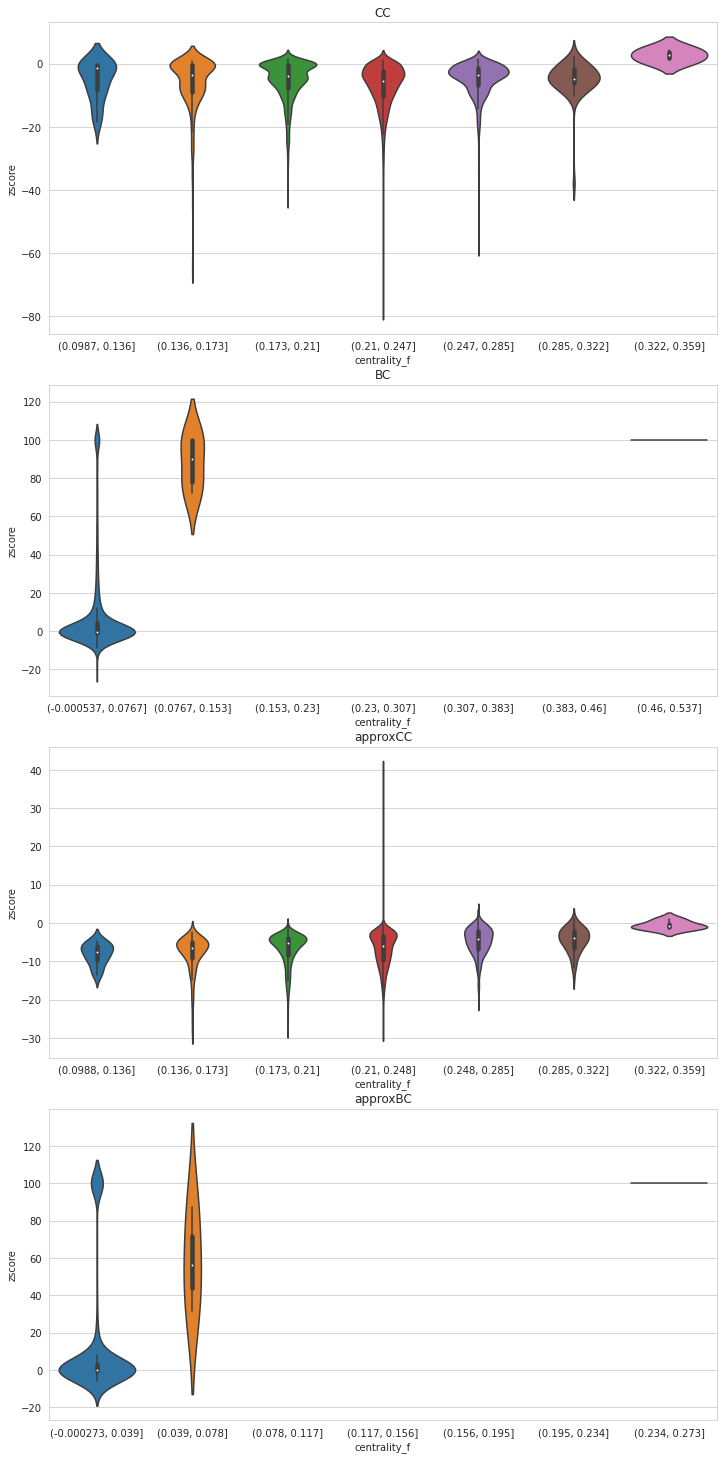

In [49]:
bins=7
df_test_BC_CL['zscore'] = df_test_BC_CL['zscore'].clip(-100,100)
df_test_approxBC_CL['zscore'] = df_test_approxBC_CL['zscore'].clip(-100,100)
fig, axes = plt.subplots(4,1,figsize=(10,20))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_CC_CL['centrality_f'], bins), y='zscore', data=df_test_CC_CL, ax=axes[0])
sns.violinplot(x=pd.cut(df_test_BC_CL['centrality_f'], bins), y='zscore', data=df_test_BC_CL, ax=axes[1])
sns.violinplot(x=pd.cut(df_test_approxCC_CL['centrality_f'], bins), y='zscore', data=df_test_approxCC_CL, ax=axes[2])
sns.violinplot(x=pd.cut(df_test_approxBC_CL['centrality_f'], bins), y='zscore', data=df_test_approxBC_CL, ax=axes[3])
axes[0].set_title("CC")
axes[1].set_title("BC")
axes[2].set_title("approxCC")
axes[3].set_title("approxBC")
plt.show()

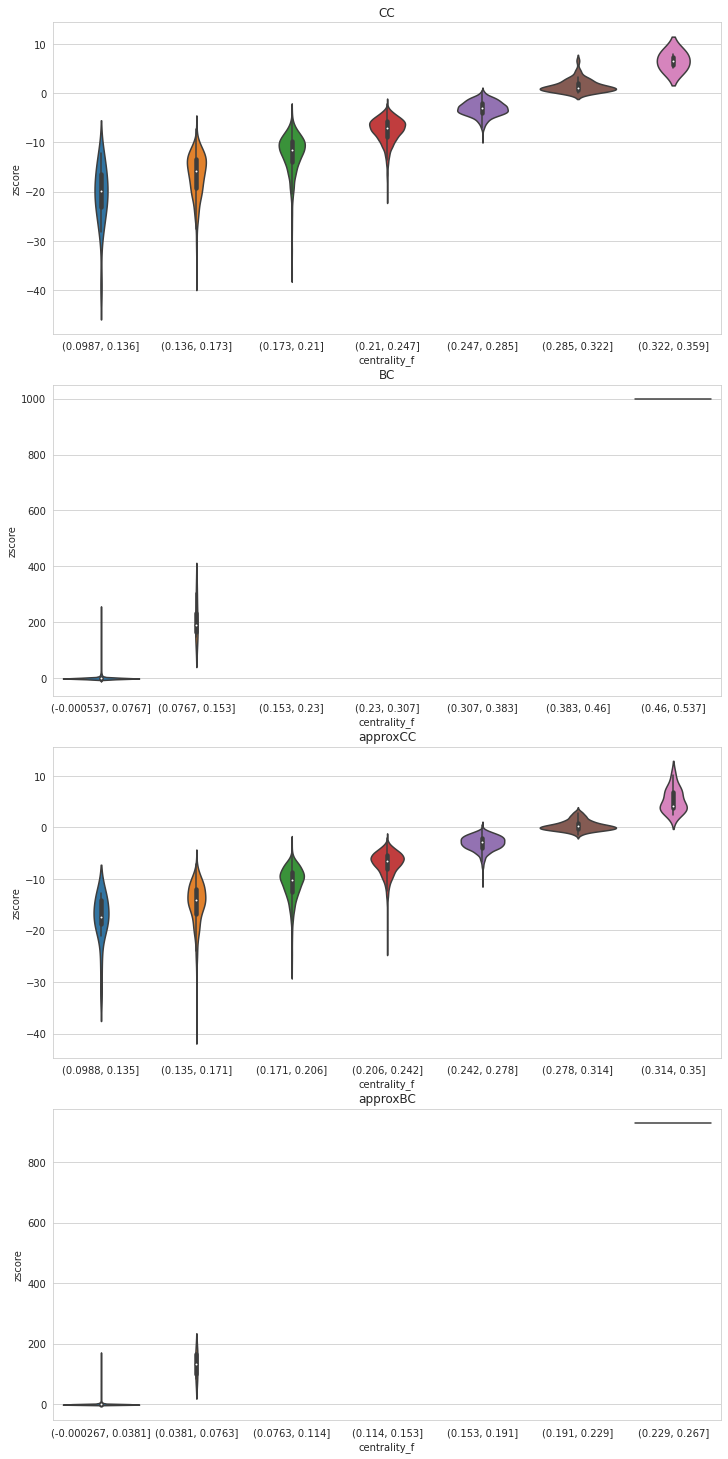

In [50]:
bins=7
fig, axes = plt.subplots(4,1,figsize=(10,20))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_CC['centrality_f'], bins), y='zscore', data=df_test_CC, ax=axes[0])
sns.violinplot(x=pd.cut(df_test_BC['centrality_f'], bins), y='zscore', data=df_test_BC, ax=axes[1])
sns.violinplot(x=pd.cut(df_test_approxCC['centrality_f'], bins), y='zscore', data=df_test_approxCC, ax=axes[2])
sns.violinplot(x=pd.cut(df_test_approxBC['centrality_f'], bins), y='zscore', data=df_test_approxBC, ax=axes[3])
axes[0].set_title("CC")
axes[1].set_title("BC")
axes[2].set_title("approxCC")
axes[3].set_title("approxBC")
plt.show()

In [51]:
df_test_LCC = generateDataFrame(nkG, "LCC", 10, "CL")

10it [00:00, 186.58it/s]


In [52]:
df_test_LCC

,zscore,clusteringCoeff_f,mean_rand,std_rand
key,,,,
0,331.186291,0.573996,0.021560,0.001668
1,179.213365,0.442356,0.021405,0.002349
2,131.530645,0.511364,0.021256,0.003726
3,501.465869,0.819048,0.021860,0.001590
4,259.865643,0.771930,0.020219,0.002893
...,...,...,...,...
5901,NaN,0.000000,0.000000,0.000000
5902,NaN,0.000000,0.000000,0.000000
5903,NaN,0.000000,0.000000,0.000000


In [53]:
r = df_test_LCC.index[np.isinf(df_test_LCC).any(1)]
#there are cases where the z-score is inf because of 0 std.
df_test_LCC.loc[r]

,zscore,clusteringCoeff_f,mean_rand,std_rand
key,,,,
2599,inf,0.500000,0.0,0.0
2684,inf,0.600000,0.0,0.0
2939,inf,0.285714,0.0,0.0
2991,inf,1.000000,0.0,0.0
3191,inf,0.380952,0.0,0.0
...,...,...,...,...
5861,inf,1.000000,0.0,0.0
5862,inf,1.000000,0.0,0.0
5874,inf,0.333333,0.0,0.0


In [54]:
# or when f and std and mean are zero
s = df_test_LCC.index[np.isnan(df_test_LCC).any(1)]
df_test_LCC.loc[s]

,zscore,clusteringCoeff_f,mean_rand,std_rand
key,,,,
2916,NaN,0.0,0.0,0.0
3193,NaN,0.0,0.0,0.0
3402,NaN,0.0,0.0,0.0
3433,NaN,0.0,0.0,0.0
3476,NaN,0.0,0.0,0.0
...,...,...,...,...
5901,NaN,0.0,0.0,0.0
5902,NaN,0.0,0.0,0.0
5903,NaN,0.0,0.0,0.0


In [55]:
np.ceil(np.max(df_test_LCC[np.isfinite(df_test_LCC)])['zscore'])

515.0

In [56]:
df_test_LCC = df_test_LCC.clip(-100,np.ceil(np.max(df_test_LCC[np.isfinite(df_test_LCC)])['zscore']))

/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cristianoc/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'LCC')

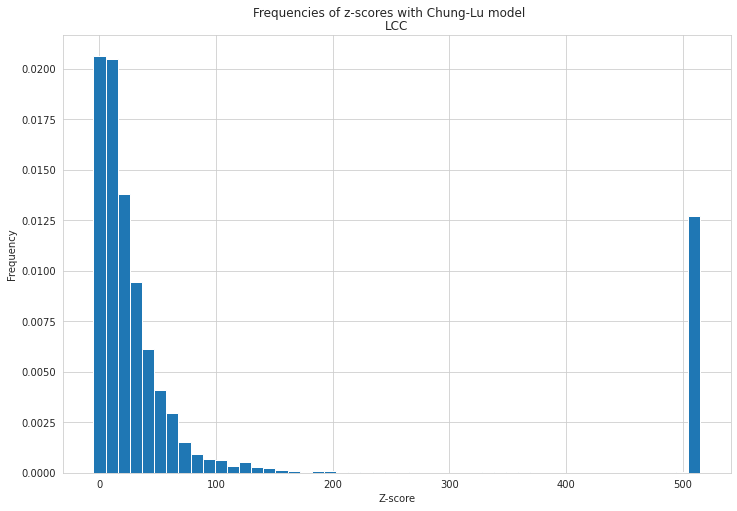

In [57]:
figure, axis = plt.subplots(1, 1, figsize=(10,7))
figure.suptitle("Frequencies of z-scores with Chung-Lu model")
figure.tight_layout(h_pad=3, w_pad=2)
axis.hist(df_test_LCC['zscore'], density=True, bins=50)
axis.set_ylabel('Frequency')
axis.set_xlabel('Z-score')
axis.set_title('LCC')

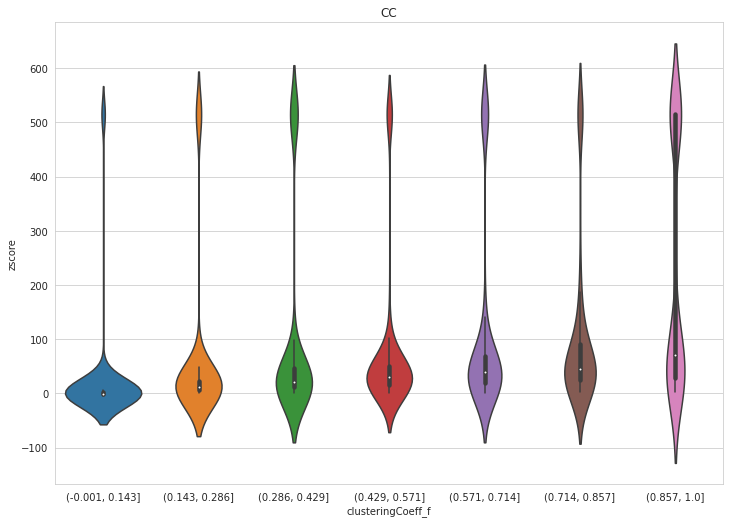

In [58]:
bins=7
fig, axes = plt.subplots(1,1,figsize=(10,7))
fig.tight_layout(h_pad=3)
sns.violinplot(x=pd.cut(df_test_LCC['clusteringCoeff_f'], bins), y='zscore', data=df_test_LCC, ax=axes)
axes.set_title("CC")
plt.show()

In [83]:
RndGraphs = generateRandGraphs("ER", 10, [nkG.numberOfNodes(), 0.0025])
globalClusteringCoeffRand = list(map(nk.globals.ClusteringCoefficient.exactGlobal,RndGraphs))
globalClusteringCoeff = nk.globals.ClusteringCoefficient.exactGlobal(nkG)
zscore_globalClusteringCoeff = zscore(globalClusteringCoeff, np.mean(globalClusteringCoeffRand), np.std(globalClusteringCoeffRand))

In [84]:
print("With Erdos Renyi model")
print("Global clustering coefficient: \n{}".format(globalClusteringCoeffRand))
print("z-score global clustering coefficient: {}".format(zscore_globalClusteringCoeff))

With Erdos Renyi model
Global clustering coefficient: 
[0.0025370445269698866, 0.002333487652156021, 0.0026092526422215384, 0.00240898726678159, 0.0025500680326680223, 0.0024238900068095396, 0.0026057783633076995, 0.002458372800239294, 0.002546102016644573, 0.0025696282695558278]
z-score global clustering coefficient: 3395.3744174740054


In [85]:
plarger_, psmaller_ = pvalues(globalClusteringCoeffRand, globalClusteringCoeff)
plarger_, psmaller_

(0.0, 1.0)

In [86]:
degreeSequence = [nkG.degree(v) for v in nkG.iterNodes()]
RndGraphs = generateRandGraphs("CL", 10, degreeSequence)
globalClusteringCoeffRand = list(map(nk.globals.ClusteringCoefficient.exactGlobal,RndGraphs))
globalClusteringCoeff = nk.globals.ClusteringCoefficient.exactGlobal(nkG)
zscore_globalClusteringCoeff = zscore(globalClusteringCoeff, np.mean(globalClusteringCoeffRand), np.std(globalClusteringCoeffRand))

In [87]:
print("With Chung-Lu model")
print("Global clustering coefficient: \n{}".format(globalClusteringCoeffRand))
print("z-score global clustering coefficient: {}".format(zscore_globalClusteringCoeff))

With Chung-Lu model
Global clustering coefficient: 
[0.021656944246834287, 0.02191627900721072, 0.022196602601587404, 0.02192922362589584, 0.02211941061693833, 0.02183923538989329, 0.02247758103065391, 0.020919813902417306, 0.021177776545630862, 0.02155335591303953]
z-score global clustering coefficient: 626.3087962904357


In [88]:
plarger_, psmaller_ = pvalues(globalClusteringCoeffRand, globalClusteringCoeff)
plarger_, psmaller_

(0.0, 1.0)